In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('missing.csv')

In [4]:
df.sample()

,area,property_type,bedRoom,bathroom,balcony,sector,society_name,Price,Study_room,Servant_room,Pooja_room,Other,floor,age,feature_score,furnish_score,rate
762,7817.0,flat,4,5,3+,102,adani mk oyster grande,2.5,0,1,1,0,10.0,Relatively New,32,33.0,3198.157861


In [5]:
train_df = df.drop(columns=['society_name','rate'])

<Axes: ylabel='feature_score'>

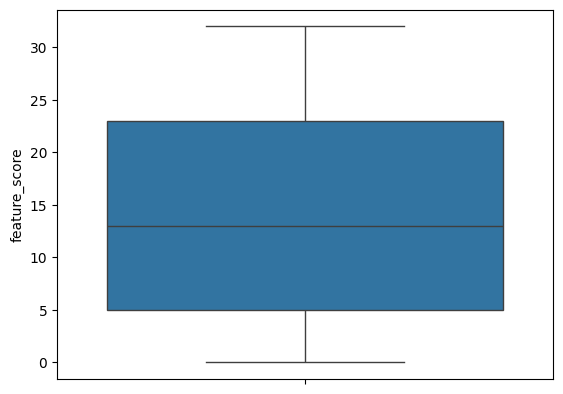

In [6]:
sns.boxplot(df['feature_score'])

In [7]:
df.feature_score.max()

np.int64(32)

In [8]:
df.feature_score.mean()

np.float64(13.905416116248349)

In [9]:
def feature(score):
    if 0 <= score <= 10:
        return "Low"
    elif 11 <= score < 19:
        return "Medium"
    elif 19 <= score <= 32:
        return "High"
    else:
        return None

In [10]:
train_df['feature_score'] = train_df['feature_score'].apply(feature)

### Floor

<Axes: ylabel='floor'>

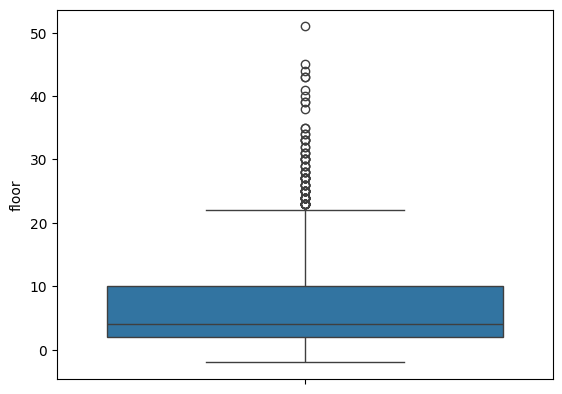

In [11]:
sns.boxplot(df['floor'])

In [12]:
def categorize_floor(floor):
    if 0 <= floor <= 2:
        return "Low Floor"
    elif 3 <= floor <= 10:
        return "Mid Floor"
    elif 11 <= floor <= 51:
        return "High Floor"
    else:
        return None 

In [13]:
train_df['floor'] = train_df['floor'].apply(categorize_floor)

In [14]:
from sklearn.preprocessing import OrdinalEncoder

# Create a copy of the original data for label encoding
data_label_encoded = train_df.copy()

categorical_cols = train_df.select_dtypes(include=['object']).columns

# Apply label encoding to categorical columns
for col in categorical_cols:
    oe = OrdinalEncoder()
    data_label_encoded[col] = oe.fit_transform(data_label_encoded[[col]])
    print(oe.categories_)

# Splitting the dataset into training and testing sets
X_label = data_label_encoded.drop('Price', axis=1)
y_label = data_label_encoded['Price']

[array(['flat', 'house'], dtype=object)]
[array(['1', '2', '3', '3+', 'No'], dtype=object)]
[array(['1', '102', '103', '104', '105', '106', '107', '108', '109', '10A',
       '11', '110', '111', '112', '113', '12', '12A', '13', '14', '15',
       '17', '17A', '17B', '17C', '1A', '2', '21', '21A', '22', '23',
       '23A', '26', '27', '28', '3', '30', '31', '32', '33', '35', '36',
       '36A', '37A', '37B', '37C', '37D', '38', '39', '3A', '4', '40',
       '41', '42', '43', '45', '46', '47', '48', '49', '5', '50', '51',
       '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61',
       '62', '63', '63A', '65', '66', '67', '67A', '68', '69', '7', '70',
       '70A', '71', '72', '73', '74', '76', '77', '78', '79', '8', '80',
       '81', '82', '82A', '83', '84', '85', '86', '88A', '88B', '89', '9',
       '90', '91', '92', '93', '95', '95A', '99', '99A', '9A', '9B',
       'A Block Sushant Lok Phase', 'Acharya Puri', 'Adarsh Nagar',
       'Alipur', 'Ambience Island', 'Anand 

## Technique 1

<Axes: >

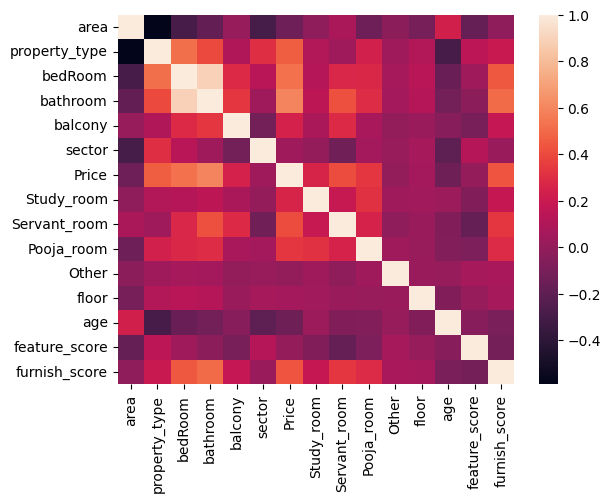

In [15]:
sns.heatmap(data_label_encoded.corr())

In [16]:
fi_df1 = data_label_encoded.corr()['Price'].iloc[0:].to_frame().reset_index().rename(columns={'index':'feature','Price':'corr_coeff'})
fi_df1

,feature,corr_coeff
0,area,-0.141149
1,property_type,0.465262
2,bedRoom,0.523488
3,bathroom,0.592594
4,balcony,0.245536
5,sector,0.039680
6,Price,1.000000
7,Study_room,0.254660
8,Servant_room,0.404207
9,Pooja_room,0.334427


## Technique 2

In [17]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_label, y_label)

# Extract feature importance scores for label encoded data
fi_df2 = pd.DataFrame({
    'feature': X_label.columns,
    'rf_importance': rf_label.feature_importances_
}).sort_values(by='rf_importance', ascending=False)

fi_df2

,feature,rf_importance
3,bathroom,0.304414
0,area,0.257108
2,bedRoom,0.090167
1,property_type,0.087129
5,sector,0.072029
7,Servant_room,0.068277
13,furnish_score,0.048250
4,balcony,0.014423
11,age,0.013293
6,Study_room,0.010680


## Technique 3 Gradient Boosting

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

# Train a Random Forest regressor on label encoded data
gb_label = GradientBoostingRegressor()
gb_label.fit(X_label, y_label)

# Extract feature importance scores for label encoded data
fi_df3 = pd.DataFrame({
    'feature': X_label.columns,
    'gb_importance': gb_label.feature_importances_
}).sort_values(by='gb_importance', ascending=False)

fi_df3

,feature,gb_importance
3,bathroom,0.347099
0,area,0.181960
1,property_type,0.140746
2,bedRoom,0.099711
7,Servant_room,0.084054
5,sector,0.071483
13,furnish_score,0.048341
6,Study_room,0.010224
8,Pooja_room,0.007093
12,feature_score,0.005747


## Technique 4 Permutation Importanceee

In [19]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

X_train_label, X_test_label, y_train_label, y_test_label = train_test_split(X_label, y_label, test_size=0.2, random_state=42)

# Train a Random Forest regressor on label encoded data
rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_train_label, y_train_label)

# Calculate Permutation Importance
perm_importance = permutation_importance(rf_label, X_test_label, y_test_label, n_repeats=30, random_state=42)

# Organize results into a DataFrame
fi_df4 = pd.DataFrame({
    'feature': X_label.columns,
    'permutation_importance': perm_importance.importances_mean
}).sort_values(by='permutation_importance', ascending=False)

fi_df4

,feature,permutation_importance
1,property_type,0.588643
0,area,0.535377
3,bathroom,0.278008
7,Servant_room,0.107315
2,bedRoom,0.059652
5,sector,0.054677
13,furnish_score,0.012027
4,balcony,0.005767
6,Study_room,0.004727
12,feature_score,0.003277


## Technique 5 Lasso

In [20]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_label)

# Train a LASSO regression model
# We'll use a relatively small value for alpha (the regularization strength) for demonstration purposes
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_scaled, y_label)

# Extract coefficients
fi_df5 = pd.DataFrame({
    'feature': X_label.columns,
    'lasso_coeff': lasso.coef_
}).sort_values(by='lasso_coeff', ascending=False)

fi_df5

,feature,lasso_coeff
3,bathroom,1.207750
1,property_type,1.090351
7,Servant_room,0.458948
13,furnish_score,0.332701
0,area,0.331877
6,Study_room,0.277331
8,Pooja_room,0.208581
12,feature_score,0.114625
4,balcony,0.071377
11,age,-0.032362


## Technique 6 RFE

In [21]:
from sklearn.feature_selection import RFE

# Initialize the base estimator
estimator = RandomForestRegressor()

# Apply RFE on the label-encoded and standardized training data
selector_label = RFE(estimator, n_features_to_select=X_label.shape[1], step=1)
selector_label = selector_label.fit(X_label, y_label)

# Get the selected features based on RFE
selected_features = X_label.columns[selector_label.support_]

# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefficients = selector_label.estimator_.feature_importances_

# Organize the results into a DataFrame
fi_df6 = pd.DataFrame({
    'feature': selected_features,
    'rfe_score': selected_coefficients
}).sort_values(by='rfe_score', ascending=False)

fi_df6

,feature,rfe_score
3,bathroom,0.292088
0,area,0.249841
2,bedRoom,0.100023
1,property_type,0.087650
5,sector,0.074914
7,Servant_room,0.064707
13,furnish_score,0.048648
4,balcony,0.014991
11,age,0.014786
6,Study_room,0.013850


## Technique 7 Linear Regression

In [22]:
# Train a linear regression model on the label-encoded and standardized training data
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y_label)

# Extract coefficients
fi_df7 = pd.DataFrame({
    'feature': X_label.columns,
    'reg_coeffs': lin_reg.coef_
}).sort_values(by='reg_coeffs', ascending=False)

fi_df7

,feature,reg_coeffs
3,bathroom,1.306844
1,property_type,1.127599
7,Servant_room,0.449958
0,area,0.352500
13,furnish_score,0.338179
6,Study_room,0.283270
8,Pooja_room,0.215683
12,feature_score,0.131913
4,balcony,0.078228
11,age,-0.043972


In [23]:
final_fi_df = fi_df1.merge(fi_df2,on='feature').merge(fi_df3,on='feature').merge(fi_df4,on='feature').merge(fi_df5,on='feature').merge(fi_df6,on='feature').merge(fi_df7,on='feature').set_index('feature')

In [24]:
final_fi_df = final_fi_df.divide(final_fi_df.sum(axis=0), axis=1)

In [25]:
final_fi_df[['rf_importance','gb_importance','permutation_importance','rfe_score']].mean(axis=1).sort_values(ascending=False)

feature
bathroom         0.277963
area             0.253230
property_type    0.167943
bedRoom          0.081501
Servant_room     0.070496
sector           0.062879
furnish_score    0.038130
Study_room       0.009404
balcony          0.008556
Pooja_room       0.007667
feature_score    0.007058
age              0.006997
floor            0.005567
Other            0.002609
dtype: float64

In [26]:
final_fi_df

,corr_coeff,rf_importance,gb_importance,permutation_importance,lasso_coeff,rfe_score,reg_coeffs
feature,,,,,,,
area,-0.046347,0.257108,0.181960,0.324011,0.096826,0.249841,0.101772
property_type,0.152771,0.087129,0.140746,0.356248,0.318113,0.087650,0.325554
bedRoom,0.171889,0.090167,0.099711,0.036101,-0.115929,0.100023,-0.148202
bathroom,0.194580,0.304414,0.347099,0.168251,0.352365,0.292088,0.377305
balcony,0.080623,0.014423,0.001319,0.003490,0.020824,0.014991,0.022586
sector,0.013029,0.072029,0.071483,0.033090,-0.017800,0.074914,-0.019858
Study_room,0.083619,0.010680,0.010224,0.002861,0.080912,0.013850,0.081784
Servant_room,0.132723,0.068277,0.084054,0.064947,0.133900,0.064707,0.129910
Pooja_room,0.109811,0.009865,0.007093,0.000026,0.060854,0.013685,0.062271


In [27]:
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=100, random_state=42)

scores = cross_val_score(rf, X_label, y_label, cv=5, scoring='r2')

In [28]:
scores.mean()

np.float64(0.6960911958905032)

In [29]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

scores = cross_val_score(rf, X_label.drop(columns=['floor', 'Other']), y_label, cv=5, scoring='r2')

In [30]:
scores.mean()

np.float64(0.696352986848787)

In [31]:
export_df = X_label
export_df['price'] = y_label

In [32]:
export_df.to_csv('final_df.csv',index=False)